In [1]:
# Validation of the steady-state simulation - Case 1: MLP with Optimal settings
## Optimal Settings are like below:
# 1. Train/Validation/Test dataset ratio = 0.7/0.2/0.1
# 2. Cd scaling -> replaced as normalization for both Cl and Cd
# 3. Seperate the ML models into the two models, a model only for Cl and the other for Cd
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from scipy import interpolate
from sklearn.model_selection import train_test_split

import datetime
%matplotlib inline

In [2]:
### Defining parameters and hyperparameters of the model

n_units=256 # Number of units in the hidden layer of the MLP network
n_layers=5
input_size = 110 + 3 # Size of input for the network (110 coefficients and 3 other parameters, time, h, beta)
lr = 1e-04 # Learning rate of the network
test_rate = 0.1 # Defines the ratio of test dataset
val_rate = 0.2 # Defines the ratio of validation dataset
n_data = 16 # Number of txt files from which the aerodynamic coefficients are extracted
batch_size = 1000 # Mini-batch size
l2_regularizer=1e-03
n_kernels=256

In [3]:
# Changing working directory

main_directory = 'D:\\VAWT_data\\flap_steady\\flap_steady'
os.chdir(main_directory)

In [4]:
## Basic parameters

c = 1 # Chord length
h = np.array([0.01, 0.02, 0.03]) * c # Height of the Gurney flaps
thickness = 0.02 * h # Thickness of the Gurney flaps
beta = np.linspace(30, 90, 5).reshape((5,1))

In [5]:
h = h.reshape((-1,1))
thickness = thickness.reshape((-1,1))

In [6]:
t_interval = 0.001
t_len = int((15-10) / t_interval)

n_beta = len(beta)# Number of the Gurney flap inclination
n_h = len(h) # Number of the height of the Gurney flaps
n_cases = n_data * t_len # Total number of cases(Number of geometries * Number of angles of attack)

cm_threshold = 10

In [7]:
## Creating Input dataset
# Defining time as input

main_directory = 'D:\\VAWT_data'
cm_dir = main_directory + "\\blade_1_cm_data"
cm_list = os.listdir(cm_dir)
os.chdir(cm_dir)

In [8]:
cm_target = [file for file in cm_list if file.endswith('.csv')]
cm_target = sorted(cm_target, key=lambda s: int(re.search(r'\d+',s).group()))
cm_target = [cm_target[-4],] + cm_target[:-4] + cm_target[-3:]

In [9]:
### Create input and output data
### This function is the main framework where data are reordered with respect to the shape the NNs require.
### Each input features are made by calling the corresponding functions, which generate the data,
### e.g., time, cm, h, beta, coordinates of airfoil and Gurney flaps, etc.
def genereate_input_output(cm_target, n_beta, t_len, normalize:bool=False):
    
    input_time_cm = time_and_cm(cm_target)
    t = input_time_cm[:,0].reshape((-1, 1))
    cm = input_time_cm[:,1].reshape((-1, 1))
    
    hh = generate_h(n_beta, t_len, normalize)
    bb = generate_beta(n_beta, t_len, normalize)
    total_coords = generate_coordinates(n_cases)
    
    # Concatenate data for input dataset
    x_para = np.hstack((t, hh, bb))
    x = total_coords.reshape((n_cases, 2, 55, 1))
    
    # Generating output dataset (depending on whether the data be normalized or not)
    if normalize==True:
        y = (cm-np.min(cm))/(np.max(cm)-np.min(cm))
    else:
        y = cm
    print("Dimension - x: ", x.shape)
    print("Dimension - y: ", y.shape)
    
    return x, x_para, y, t, cm

In [10]:
## Creating time for input, and Cm (moment coefficient) for output
def time_and_cm(cm_target):
    cm_df = pd.DataFrame()
    for i, file in enumerate(cm_target):
        df = pd.DataFrame()
        
        data = pd.read_csv(file, header=None)
        df = pd.concat([df, data], axis=0)
        
        time = df.iloc[:,0].values
        cm = df.iloc[:,1].values
        
        time_beUsed = time[np.where(np.logical_and(time>=10, time<15))]
        cm_beUsed = cm[np.where(np.logical_and(time>=10, time<15))]
        
        # Handle the time that is duplicated because of digits
        # Also, outliers are regulated at the second conditional statement.
        time_beUsed = handler_time(time_beUsed)
        cm_beUsed = handler_cm(cm_beUsed)
        
        linear_func = interpolate.interp1d(time_beUsed, cm_beUsed,
                                           bounds_error=False,kind='quadratic',
                                           fill_value='extrapolate')
        time_interp = np.arange(10, 15, t_interval).reshape((-1,1))
        cm_interp=linear_func(time_interp).reshape((-1,1))
        
        cm_df = pd.concat([cm_df, pd.DataFrame(np.hstack((time_interp, cm_interp)))], axis=0)
    
    input_time_cm = cm_df.iloc[:,:].values
    print("Dimension - time and $C_m$: ", input_time_cm.shape)
    return input_time_cm

In [11]:
# Handling duplicated time value
def handler_time(time_beUsed):
    for i in range(len(time_beUsed)):
        if time_beUsed[i]==time_beUsed[i-1]:
            time_beUsed[i] += 0.0005
            
    return time_beUsed

In [12]:
# Handling outlier, (if there are)
def handler_cm(cm_beUsed):
    period = int(len(cm_beUsed) / 5)
    for i in range(len(cm_beUsed)):
        if np.abs(cm_beUsed[i]-cm_beUsed[i-1])>cm_threshold:
            cm_beUsed[i-1] = cm_beUsed[i-1 + period]
            
    return cm_beUsed

In [13]:
## Defining beta, the Gurney flap inclination
## In case of mere NACA0018, the bb in those indexes are considered as zero.
def generate_beta(n_beta=n_beta, t_len=t_len, normalize=True):

    beta_0 = np.zeros((t_len,1)) # Values for sheer NACA0018
    b_ = np.ones((t_len,1)) # Template for the inclination for a single h and single beta
    bb_imp = np.zeros((t_len*n_beta,1))

    for j in range(n_beta):
        b_imp = b_ * beta[j]
        bb_imp[t_len*j:t_len*(j+1),:] = b_imp[:,:]

    bb_imp = bb_imp.reshape((-1,1))
    bb = np.vstack((beta_0, bb_imp, bb_imp, bb_imp))
    if normalize==True:
        bb = bb / np.max(beta)
    
    print("Dimension - inclination(beta): ", bb.shape)

    return bb

In [14]:
## Defining the Gurney flap height
## In case of mere NACA0018, the hh in those indexes are considered as zero.
def generate_h(n_beta=n_beta, t_len=t_len, normalize:bool=True):
    hh = np.concatenate((np.zeros(t_len), h[0]*np.ones(n_beta*t_len), h[1]*np.ones(n_beta*t_len), h[2]*np.ones(n_beta*t_len)))
    hh = hh.reshape((-1,1))
    
    if normalize==True:
        hh = hh / np.max(h)
    
    print("Dimension - heights of Gurney flaps: ", hh.shape)
    return hh

In [15]:
## Generates coordinate data of NACA0018 airfoil and Gurney flaps
def generate_coordinates(n_cases):
    origin_coord = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out\\airfoil15"

    csv_file_name = origin_coord + '\\airfoilOut15.txt'
    data = pd.read_csv(csv_file_name, header=None)
    
    baseline_coord_high = data.iloc[0,:]
    baseline_coord_low = data.iloc[1,:]
    baseline_coord = np.hstack((baseline_coord_high, baseline_coord_low)).reshape((1,-1))
    airfoil_coord = np.repeat(baseline_coord, n_cases, axis=0)
    print("Dimension - airfoil coordinates: ", airfoil_coord.shape)
    
    flap_coords= coord_with_flaps(n_cases)
    total_coords = np.hstack((airfoil_coord, flap_coords))
    
    print("Dimension - total coordinates: ", total_coords.shape)
    
    return total_coords

In [16]:
# Generating data of Gurney flap coordinates
def coord_with_flaps(n_cases):
    flap_left = np.zeros((15,5))
    flap_right = np.zeros((15,5))

    for i in range(n_h):
        # Defining coordinates of the flaps with respect to beta=90 degree.
        yLeft = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
        yRight = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
        xLeft = 0.5*np.ones((5,1)) - 0.02*h[i]
        xRight = 0.5*np.ones((5,1))

        for j in range(n_beta):
            betaValue = beta[j]

            # Rotating transformation
            rotateTransf = np.array([[np.cos(90-betaValue), -np.sin(90-betaValue)],
                                     [np.sin(90-betaValue), np.cos(90-betaValue)]])
            rotateTransf = rotateTransf.reshape((2,2))

            LeftImp = np.hstack((xLeft-0.5, yLeft))
            RightImp = np.hstack((xRight-0.5, yRight))

            rotatedFlapLeft = rotateTransf @ LeftImp.T # shape: 2*5 (x-coordinates on first row, y-coordinates on second row)
            rotatedFlapRight = rotateTransf @ RightImp.T

            # All we need is the y-coordinates of the flaps
            flap_left[5*i+j,:] = rotatedFlapLeft[1,:]
            flap_right[5*i+j,:] = rotatedFlapRight[1,:]
    
    flap_coords = np.hstack((flap_left, np.flip(flap_right, axis=1)))
    flap_coords2 = np.zeros((n_cases, 10))
    
    for i in range(t_len, n_cases):
        flap_coords2[i,:] = flap_coords[i%15,:]
    print("Dimension - coord with flaps: ", flap_coords2.shape)
    
    return flap_coords2

In [17]:
# Generating x, y and cm (for denormalizing)
x, x_para, y, t, cm = genereate_input_output(cm_target, n_beta, t_len, normalize=True)

Dimension - time and $C_m$:  (80000, 2)
Dimension - heights of Gurney flaps:  (80000, 1)
Dimension - inclination(beta):  (80000, 1)
Dimension - airfoil coordinates:  (80000, 100)
Dimension - coord with flaps:  (80000, 10)
Dimension - total coordinates:  (80000, 110)
Dimension - x:  (80000, 2, 55, 1)
Dimension - y:  (80000, 1)


In [18]:
cm

array([[0.038717  ],
       [0.038266  ],
       [0.037764  ],
       ...,
       [0.0093676 ],
       [0.0080793 ],
       [0.00611161]])

In [19]:
def dataset_split(x, x_para, y, test_rate, random_state=1, **kwargs):
    if kwargs.get('validation')==True:
        val_rate = kwargs.get('val_rate')
        x_all, x_test, x_para_all, x_para_test, y_all, y_test = train_test_split(x,x_para,
                                                                                 y, test_size=test_rate,
                                                                                 random_state=kwargs.get('random_state'))
        x_train, x_val, x_para_train, x_para_val, y_train, y_val = train_test_split(x_all, x_para_all,
                                                                                    y_all, test_size=val_rate/(1-test_rate),
                                                                                    random_state=kwargs.get('random_state'))
        return x_train, x_val, x_test, x_para_train, x_para_val, x_para_test, y_train, y_val, y_test
    else:
        x_train, x_test, x_para_train, x_para_test, y_train, y_test = train_test_split(x, x_para, y,
                                                                                       test_size=test_rate, random_state=kwargs.get('random_state'))
        return x_train, x_test, y_train, y_test

In [20]:
x_train, x_val, x_test, x_para_train, x_para_val, x_para_test, y_train, y_val, y_test = dataset_split(x, x_para, y, test_rate, val_rate=val_rate,
                                                                                                      validation=True, random_state=26)

In [21]:
y_val

array([[0.0013549 ],
       [0.00145402],
       [0.00113346],
       ...,
       [0.00051332],
       [0.00336457],
       [0.00254655]])

In [22]:
def make_aeroCNN1_model(n_kernels, num_layer:int = 5): # This function can only generate model with at least 3 hidden layers
    input_1 = tf.keras.Input(shape=(2,55,1))
    input_2 = tf.keras.Input(shape=(3))

    x_conv1 = tf.keras.layers.Conv2D(filters=n_kernels, kernel_size=(2,2), strides=1, padding='same',
                                     activation='relu', name='convLayer',
                                     kernel_initializer='he_uniform',
                                     kernel_regularizer=regularizers.l2(l2_regularizer))(input_1)
    x_pool = tf.keras.layers.MaxPool2D(pool_size=(2,2))(x_conv1)

    x_flat = tf.keras.layers.Flatten()(x_pool)
    x_concat = tf.keras.layers.Concatenate()([x_flat, input_2])
    # The first hidden layer
    x_fc = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc1',
                                kernel_initializer='he_uniform',
                                kernel_regularizer=regularizers.l2(l2_regularizer))(x_concat)
    
    # The other hidden layers, which will be placed between the first hidden layer and the last hidden layer.
    # The number of layers that the user desires is input of this function.
    for i in range(0, num_layer-2):
        x_fc = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc%d' % (i+2),
                                     kernel_initializer='he_uniform',
                                     kernel_regularizer=regularizers.l2(l2_regularizer))(x_fc)
    
    # The last hidden layer
    x_fc_final = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc%d' % num_layer,
                                       kernel_initializer='he_uniform',
                                       kernel_regularizer=regularizers.l2(l2_regularizer))(x_fc)

    # The output layer
    output_data = tf.keras.layers.Dense(units=1, activation='linear', name='outputLayer')(x_fc_final)
    
    # MLP(FC layer)-based
    model = tf.keras.Model([input_1, input_2], output_data)
    
    return model

In [23]:
model = make_aeroCNN1_model(n_kernels, num_layer=n_layers)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2, 55, 1)]   0           []                               
                                                                                                  
 convLayer (Conv2D)             (None, 2, 55, 256)   1280        ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 1, 27, 256)   0           ['convLayer[0][0]']              
                                                                                                  
 flatten (Flatten)              (None, 6912)         0           ['max_pooling2d[0][0]']          
                                                                                              

In [24]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [25]:
model_directory = "D:\\TrainedModels\\20221218"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)

In [26]:
ckpt_name = model_directory + "20221218unsteadyPrediction_AeroCNN1_val_"+str(val_rate) + "_test"+str(test_rate)+ "_" +str(n_layers)+"layers_"+ str(n_units) +"units_checkpoint.h5"

ckpt = tf.keras.callbacks.ModelCheckpoint(ckpt_name, monitor="val_loss", mode='min', verbose=1, save_best_only=True)

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=500, min_delta=1e-09,
                                      restore_best_weights=True, verbose=1)
rp = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=100, factor=0.5,
                                          min_delta = 1e-10, min_lr=1e-06, verbose=1)

In [27]:
STEP_SIZE_TRAIN = len(x_train)//batch_size
VALIDATION_STEPS = len(x_val)//batch_size

In [28]:
start = datetime.datetime.now()
history = model.fit([x_train, x_para_train], y_train, batch_size=batch_size,
                    validation_data=([x_val, x_para_val], y_val),
                    steps_per_epoch = STEP_SIZE_TRAIN, validation_steps=VALIDATION_STEPS,
                    epochs=10000, shuffle=True, callbacks=[es, ckpt, rp])
end = datetime.datetime.now()

Epoch 1/10000
55/55 [==============================] - ETA: 0s - loss: 2.9139 - rmse: 0.0632
Epoch 1: val_loss improved from inf to 2.76219, saving model to D:\TrainedModels\2022121820221218unsteadyPrediction_AeroCNN1_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 4s 16ms/step - loss: 2.9139 - rmse: 0.0632 - val_loss: 2.7622 - val_rmse: 0.0052 - lr: 1.0000e-04
Epoch 2/10000
52/55 [===========================>..] - ETA: 0s - loss: 2.6424 - rmse: 0.0062
Epoch 2: val_loss improved from 2.76219 to 2.51259, saving model to D:\TrainedModels\2022121820221218unsteadyPrediction_AeroCNN1_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 1s 11ms/step - loss: 2.6358 - rmse: 0.0060 - val_loss: 2.5126 - val_rmse: 0.0022 - lr: 1.0000e-04
Epoch 3/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.4166 - rmse: 0.0056
Epoch 3: val_loss improved from 2.51259 to 2.30403, saving model to D:\TrainedModels\2022121820

52/55 [===========================>..] - ETA: 0s - loss: 0.7545 - rmse: 0.0049
Epoch 21: val_loss improved from 0.77269 to 0.73391, saving model to D:\TrainedModels\2022121820221218unsteadyPrediction_AeroCNN1_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 1s 11ms/step - loss: 0.7534 - rmse: 0.0048 - val_loss: 0.7339 - val_rmse: 0.0015 - lr: 1.0000e-04
Epoch 22/10000
50/55 [==========================>...] - ETA: 0s - loss: 0.7177 - rmse: 0.0038
Epoch 22: val_loss improved from 0.73391 to 0.69809, saving model to D:\TrainedModels\2022121820221218unsteadyPrediction_AeroCNN1_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 1s 12ms/step - loss: 0.7161 - rmse: 0.0037 - val_loss: 0.6981 - val_rmse: 0.0015 - lr: 1.0000e-04
Epoch 23/10000
50/55 [==========================>...] - ETA: 0s - loss: 0.6832 - rmse: 0.0066
Epoch 23: val_loss improved from 0.69809 to 0.66501, saving model to D:\TrainedModels\202212182022121

49/55 [=========================>....] - ETA: 0s - loss: 0.3518 - rmse: 0.0055
Epoch 41: val_loss improved from 0.35609 to 0.34639, saving model to D:\TrainedModels\2022121820221218unsteadyPrediction_AeroCNN1_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 1s 12ms/step - loss: 0.3513 - rmse: 0.0052 - val_loss: 0.3464 - val_rmse: 0.0015 - lr: 1.0000e-04
Epoch 42/10000
50/55 [==========================>...] - ETA: 0s - loss: 0.3423 - rmse: 0.0075
Epoch 42: val_loss improved from 0.34639 to 0.33718, saving model to D:\TrainedModels\2022121820221218unsteadyPrediction_AeroCNN1_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 1s 12ms/step - loss: 0.3419 - rmse: 0.0072 - val_loss: 0.3372 - val_rmse: 0.0014 - lr: 1.0000e-04
Epoch 43/10000
50/55 [==========================>...] - ETA: 0s - loss: 0.3332 - rmse: 0.0018
Epoch 43: val_loss improved from 0.33718 to 0.32842, saving model to D:\TrainedModels\202212182022121

49/55 [=========================>....] - ETA: 0s - loss: 0.2218 - rmse: 0.0048
Epoch 61: val_loss improved from 0.22378 to 0.21931, saving model to D:\TrainedModels\2022121820221218unsteadyPrediction_AeroCNN1_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 1s 12ms/step - loss: 0.2216 - rmse: 0.0047 - val_loss: 0.2193 - val_rmse: 0.0014 - lr: 1.0000e-04
Epoch 62/10000
50/55 [==========================>...] - ETA: 0s - loss: 0.2174 - rmse: 0.0060
Epoch 62: val_loss improved from 0.21931 to 0.21497, saving model to D:\TrainedModels\2022121820221218unsteadyPrediction_AeroCNN1_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 1s 11ms/step - loss: 0.2172 - rmse: 0.0057 - val_loss: 0.2150 - val_rmse: 0.0014 - lr: 1.0000e-04
Epoch 63/10000
50/55 [==========================>...] - ETA: 0s - loss: 0.2131 - rmse: 0.0053
Epoch 63: val_loss improved from 0.21497 to 0.21075, saving model to D:\TrainedModels\202212182022121

50/55 [==========================>...] - ETA: 0s - loss: 0.1513 - rmse: 0.0072
Epoch 81: val_loss improved from 0.15254 to 0.14972, saving model to D:\TrainedModels\2022121820221218unsteadyPrediction_AeroCNN1_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 1s 11ms/step - loss: 0.1512 - rmse: 0.0069 - val_loss: 0.1497 - val_rmse: 0.0014 - lr: 1.0000e-04
Epoch 82/10000
50/55 [==========================>...] - ETA: 0s - loss: 0.1485 - rmse: 0.0029
Epoch 82: val_loss improved from 0.14972 to 0.14695, saving model to D:\TrainedModels\2022121820221218unsteadyPrediction_AeroCNN1_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 1s 11ms/step - loss: 0.1484 - rmse: 0.0028 - val_loss: 0.1469 - val_rmse: 0.0014 - lr: 1.0000e-04
Epoch 83/10000
50/55 [==========================>...] - ETA: 0s - loss: 0.1458 - rmse: 0.0070
Epoch 83: val_loss improved from 0.14695 to 0.14423, saving model to D:\TrainedModels\202212182022121

50/55 [==========================>...] - ETA: 0s - loss: 0.1034 - rmse: 0.0055
Epoch 101: val_loss improved from 0.10425 to 0.10221, saving model to D:\TrainedModels\2022121820221218unsteadyPrediction_AeroCNN1_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 1s 11ms/step - loss: 0.1033 - rmse: 0.0052 - val_loss: 0.1022 - val_rmse: 0.0014 - lr: 1.0000e-04
Epoch 102/10000
50/55 [==========================>...] - ETA: 0s - loss: 0.1013 - rmse: 0.0056
Epoch 102: val_loss improved from 0.10221 to 0.10021, saving model to D:\TrainedModels\2022121820221218unsteadyPrediction_AeroCNN1_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 1s 11ms/step - loss: 0.1013 - rmse: 0.0053 - val_loss: 0.1002 - val_rmse: 0.0014 - lr: 1.0000e-04
Epoch 103/10000
50/55 [==========================>...] - ETA: 0s - loss: 0.0994 - rmse: 0.0055
Epoch 103: val_loss improved from 0.10021 to 0.09823, saving model to D:\TrainedModels\2022121820

Epoch 121/10000
49/55 [=========================>....] - ETA: 0s - loss: 0.0682 - rmse: 0.0055
Epoch 121: val_loss improved from 0.06879 to 0.06729, saving model to D:\TrainedModels\2022121820221218unsteadyPrediction_AeroCNN1_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 1s 12ms/step - loss: 0.0681 - rmse: 0.0052 - val_loss: 0.0673 - val_rmse: 0.0014 - lr: 1.0000e-04
Epoch 122/10000
50/55 [==========================>...] - ETA: 0s - loss: 0.0667 - rmse: 0.0055
Epoch 122: val_loss improved from 0.06729 to 0.06581, saving model to D:\TrainedModels\2022121820221218unsteadyPrediction_AeroCNN1_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 1s 12ms/step - loss: 0.0666 - rmse: 0.0052 - val_loss: 0.0658 - val_rmse: 0.0014 - lr: 1.0000e-04
Epoch 123/10000
55/55 [==============================] - ETA: 0s - loss: 0.0651 - rmse: 0.0052
Epoch 123: val_loss improved from 0.06581 to 0.06435, saving model to D:\TrainedM

Epoch 141/10000
50/55 [==========================>...] - ETA: 0s - loss: 0.0425 - rmse: 0.0021
Epoch 141: val_loss improved from 0.04293 to 0.04186, saving model to D:\TrainedModels\2022121820221218unsteadyPrediction_AeroCNN1_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 1s 11ms/step - loss: 0.0424 - rmse: 0.0031 - val_loss: 0.0419 - val_rmse: 0.0014 - lr: 1.0000e-04
Epoch 142/10000
50/55 [==========================>...] - ETA: 0s - loss: 0.0414 - rmse: 0.0047
Epoch 142: val_loss improved from 0.04186 to 0.04080, saving model to D:\TrainedModels\2022121820221218unsteadyPrediction_AeroCNN1_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 1s 14ms/step - loss: 0.0414 - rmse: 0.0045 - val_loss: 0.0408 - val_rmse: 0.0014 - lr: 1.0000e-04
Epoch 143/10000
50/55 [==========================>...] - ETA: 0s - loss: 0.0404 - rmse: 0.0060
Epoch 143: val_loss improved from 0.04080 to 0.03977, saving model to D:\TrainedM

Epoch 161/10000
50/55 [==========================>...] - ETA: 0s - loss: 0.0246 - rmse: 0.0030
Epoch 161: val_loss improved from 0.02488 to 0.02416, saving model to D:\TrainedModels\2022121820221218unsteadyPrediction_AeroCNN1_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 1s 12ms/step - loss: 0.0245 - rmse: 0.0032 - val_loss: 0.0242 - val_rmse: 0.0014 - lr: 1.0000e-04
Epoch 162/10000
50/55 [==========================>...] - ETA: 0s - loss: 0.0239 - rmse: 0.0053
Epoch 162: val_loss improved from 0.02416 to 0.02345, saving model to D:\TrainedModels\2022121820221218unsteadyPrediction_AeroCNN1_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 1s 12ms/step - loss: 0.0238 - rmse: 0.0050 - val_loss: 0.0234 - val_rmse: 0.0014 - lr: 1.0000e-04
Epoch 163/10000
50/55 [==========================>...] - ETA: 0s - loss: 0.0232 - rmse: 0.0055
Epoch 163: val_loss improved from 0.02345 to 0.02275, saving model to D:\TrainedM

Epoch 181/10000
49/55 [=========================>....] - ETA: 0s - loss: 0.0129 - rmse: 0.0054  
Epoch 181: val_loss improved from 0.01307 to 0.01262, saving model to D:\TrainedModels\2022121820221218unsteadyPrediction_AeroCNN1_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 1s 12ms/step - loss: 0.0129 - rmse: 0.0051 - val_loss: 0.0126 - val_rmse: 0.0014 - lr: 1.0000e-04
Epoch 182/10000
54/55 [============================>.] - ETA: 0s - loss: 0.0124 - rmse: 0.0048
Epoch 182: val_loss improved from 0.01262 to 0.01217, saving model to D:\TrainedModels\2022121820221218unsteadyPrediction_AeroCNN1_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 1s 12ms/step - loss: 0.0124 - rmse: 0.0048 - val_loss: 0.0122 - val_rmse: 0.0014 - lr: 1.0000e-04
Epoch 183/10000
49/55 [=========================>....] - ETA: 0s - loss: 0.0120 - rmse: 0.0030
Epoch 183: val_loss improved from 0.01217 to 0.01174, saving model to D:\Traine

Epoch 201/10000
50/55 [==========================>...] - ETA: 0s - loss: 0.0059 - rmse: 0.0067
Epoch 201: val_loss improved from 0.00600 to 0.00574, saving model to D:\TrainedModels\2022121820221218unsteadyPrediction_AeroCNN1_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 1s 12ms/step - loss: 0.0059 - rmse: 0.0068 - val_loss: 0.0057 - val_rmse: 0.0014 - lr: 1.0000e-04
Epoch 202/10000
55/55 [==============================] - ETA: 0s - loss: 0.0056 - rmse: 0.0018
Epoch 202: val_loss improved from 0.00574 to 0.00549, saving model to D:\TrainedModels\2022121820221218unsteadyPrediction_AeroCNN1_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 1s 12ms/step - loss: 0.0056 - rmse: 0.0018 - val_loss: 0.0055 - val_rmse: 0.0014 - lr: 1.0000e-04
Epoch 203/10000
50/55 [==========================>...] - ETA: 0s - loss: 0.0054 - rmse: 0.0059
Epoch 203: val_loss improved from 0.00549 to 0.00526, saving model to D:\TrainedM

Epoch 221/10000
50/55 [==========================>...] - ETA: 0s - loss: 0.0022 - rmse: 0.0055
Epoch 221: val_loss improved from 0.00226 to 0.00214, saving model to D:\TrainedModels\2022121820221218unsteadyPrediction_AeroCNN1_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 1s 12ms/step - loss: 0.0022 - rmse: 0.0052 - val_loss: 0.0021 - val_rmse: 0.0014 - lr: 1.0000e-04
Epoch 222/10000
50/55 [==========================>...] - ETA: 0s - loss: 0.0021 - rmse: 0.0055
Epoch 222: val_loss improved from 0.00214 to 0.00202, saving model to D:\TrainedModels\2022121820221218unsteadyPrediction_AeroCNN1_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 1s 11ms/step - loss: 0.0021 - rmse: 0.0052 - val_loss: 0.0020 - val_rmse: 0.0014 - lr: 1.0000e-04
Epoch 223/10000
50/55 [==========================>...] - ETA: 0s - loss: 0.0020 - rmse: 0.0055
Epoch 223: val_loss improved from 0.00202 to 0.00191, saving model to D:\TrainedM

Epoch 241/10000
50/55 [==========================>...] - ETA: 0s - loss: 6.3910e-04 - rmse: 0.0055
Epoch 241: val_loss improved from 0.00063 to 0.00059, saving model to D:\TrainedModels\2022121820221218unsteadyPrediction_AeroCNN1_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 1s 11ms/step - loss: 6.3440e-04 - rmse: 0.0052 - val_loss: 5.8627e-04 - val_rmse: 0.0014 - lr: 1.0000e-04
Epoch 242/10000
50/55 [==========================>...] - ETA: 0s - loss: 5.9249e-04 - rmse: 0.0052
Epoch 242: val_loss improved from 0.00059 to 0.00054, saving model to D:\TrainedModels\2022121820221218unsteadyPrediction_AeroCNN1_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 1s 11ms/step - loss: 5.8817e-04 - rmse: 0.0050 - val_loss: 5.4346e-04 - val_rmse: 0.0014 - lr: 1.0000e-04
Epoch 243/10000
50/55 [==========================>...] - ETA: 0s - loss: 5.5293e-04 - rmse: 0.0054
Epoch 243: val_loss improved from 0.00054 to 0.00050,

55/55 [==============================] - 1s 12ms/step - loss: 1.4567e-04 - rmse: 0.0057 - val_loss: 1.0870e-04 - val_rmse: 0.0014 - lr: 1.0000e-04
Epoch 261/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.2482e-04 - rmse: 0.0048
Epoch 261: val_loss improved from 0.00011 to 0.00010, saving model to D:\TrainedModels\2022121820221218unsteadyPrediction_AeroCNN1_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 1s 12ms/step - loss: 1.2489e-04 - rmse: 0.0049 - val_loss: 9.7777e-05 - val_rmse: 0.0014 - lr: 1.0000e-04
Epoch 262/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.2572e-04 - rmse: 0.0059
Epoch 262: val_loss improved from 0.00010 to 0.00009, saving model to D:\TrainedModels\2022121820221218unsteadyPrediction_AeroCNN1_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 1s 12ms/step - loss: 1.2337e-04 - rmse: 0.0057 - val_loss: 8.7768e-05 - val_rmse: 0.0014 - lr: 1.0000e-04
Epoch

Epoch 280/10000
50/55 [==========================>...] - ETA: 0s - loss: 3.8034e-05 - rmse: 0.0055
Epoch 280: val_loss improved from 0.00001 to 0.00001, saving model to D:\TrainedModels\2022121820221218unsteadyPrediction_AeroCNN1_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 1s 12ms/step - loss: 3.5356e-05 - rmse: 0.0052 - val_loss: 9.2753e-06 - val_rmse: 0.0014 - lr: 1.0000e-04
Epoch 281/10000
50/55 [==========================>...] - ETA: 0s - loss: 3.0567e-05 - rmse: 0.0049
Epoch 281: val_loss improved from 0.00001 to 0.00001, saving model to D:\TrainedModels\2022121820221218unsteadyPrediction_AeroCNN1_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 1s 11ms/step - loss: 3.4108e-05 - rmse: 0.0052 - val_loss: 8.1300e-06 - val_rmse: 0.0014 - lr: 1.0000e-04
Epoch 282/10000
50/55 [==========================>...] - ETA: 0s - loss: 3.5750e-05 - rmse: 0.0055
Epoch 282: val_loss improved from 0.00001 to 0.00001,

55/55 [==============================] - 1s 12ms/step - loss: 7.9582e-06 - rmse: 0.0028 - val_loss: 1.9912e-06 - val_rmse: 0.0014 - lr: 1.0000e-04
Epoch 300/10000
49/55 [=========================>....] - ETA: 0s - loss: 5.2156e-05 - rmse: 0.0072
Epoch 300: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121820221218unsteadyPrediction_AeroCNN1_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 1s 12ms/step - loss: 4.6552e-05 - rmse: 0.0068 - val_loss: 1.9682e-06 - val_rmse: 0.0014 - lr: 1.0000e-04
Epoch 301/10000
49/55 [=========================>....] - ETA: 0s - loss: 9.4991e-06 - rmse: 0.0031
Epoch 301: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121820221218unsteadyPrediction_AeroCNN1_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 1s 12ms/step - loss: 8.5478e-06 - rmse: 0.0029 - val_loss: 1.9629e-06 - val_rmse: 0.0014 - lr: 1.0000e-04
Epoch

Epoch 325/10000
49/55 [=========================>....] - ETA: 0s - loss: 3.0526e-05 - rmse: 0.0055
Epoch 325: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 10ms/step - loss: 2.8334e-05 - rmse: 0.0053 - val_loss: 1.8676e-06 - val_rmse: 0.0014 - lr: 1.0000e-04
Epoch 326/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.8754e-05 - rmse: 0.0054
Epoch 326: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 10ms/step - loss: 2.6721e-05 - rmse: 0.0052 - val_loss: 1.9050e-06 - val_rmse: 0.0014 - lr: 1.0000e-04
Epoch 327/10000
50/55 [==========================>...] - ETA: 0s - loss: 3.6609e-05 - rmse: 0.0061
Epoch 327: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 10ms/step - loss: 3.3511e-05 - rmse: 0.0058 - val_loss: 1.8818e-06 - val_rmse: 0.0014 - lr: 1.0000e-04
Epoch 328/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.2527e-05 - rmse: 0.0047
Epoch 328: val_l

55/55 [==============================] - 1s 10ms/step - loss: 4.5244e-05 - rmse: 0.0067 - val_loss: 1.8709e-06 - val_rmse: 0.0014 - lr: 1.0000e-04
Epoch 353/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.5090e-05 - rmse: 0.0050
Epoch 353: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 10ms/step - loss: 2.2872e-05 - rmse: 0.0048 - val_loss: 1.8947e-06 - val_rmse: 0.0014 - lr: 1.0000e-04
Epoch 354/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.8646e-05 - rmse: 0.0054
Epoch 354: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 10ms/step - loss: 2.5597e-05 - rmse: 0.0051 - val_loss: 1.8600e-06 - val_rmse: 0.0014 - lr: 1.0000e-04
Epoch 355/10000
50/55 [==========================>...] - ETA: 0s - loss: 3.0126e-05 - rmse: 0.0055
Epoch 355: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 10ms/step - loss: 2.7492e-05 - rmse: 0.0052 - val_loss: 1.9817e-06 - va

50/55 [==========================>...] - ETA: 0s - loss: 2.3716e-05 - rmse: 0.0049
Epoch 380: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 10ms/step - loss: 2.2138e-05 - rmse: 0.0047 - val_loss: 1.8607e-06 - val_rmse: 0.0014 - lr: 1.0000e-04
Epoch 381/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.9369e-05 - rmse: 0.0054
Epoch 381: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 10ms/step - loss: 2.6759e-05 - rmse: 0.0052 - val_loss: 1.8588e-06 - val_rmse: 0.0014 - lr: 1.0000e-04
Epoch 382/10000
50/55 [==========================>...] - ETA: 0s - loss: 3.6190e-05 - rmse: 0.0060
Epoch 382: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 10ms/step - loss: 3.2968e-05 - rmse: 0.0057 - val_loss: 1.8849e-06 - val_rmse: 0.0014 - lr: 1.0000e-04
Epoch 383/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.3738e-05 - rmse: 0.0049
Epoch 383: val_loss did not impr

Epoch 408/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.8183e-05 - rmse: 0.0053
Epoch 408: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 10ms/step - loss: 2.5681e-05 - rmse: 0.0051 - val_loss: 1.8757e-06 - val_rmse: 0.0014 - lr: 1.0000e-04
Epoch 409/10000
49/55 [=========================>....] - ETA: 0s - loss: 3.2858e-05 - rmse: 0.0057
Epoch 409: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 10ms/step - loss: 2.9859e-05 - rmse: 0.0055 - val_loss: 1.8600e-06 - val_rmse: 0.0014 - lr: 1.0000e-04
Epoch 410/10000
55/55 [==============================] - ETA: 0s - loss: 2.1771e-05 - rmse: 0.0047
Epoch 410: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 10ms/step - loss: 2.1771e-05 - rmse: 0.0047 - val_loss: 1.8595e-06 - val_rmse: 0.0014 - lr: 1.0000e-04
Epoch 411/10000
50/55 [==========================>...] - ETA: 0s - loss: 3.5978e-05 - rmse: 0.0060
Epoch 411: val_l

Epoch 436/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.1149e-05 - rmse: 0.0033
Epoch 436: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 9ms/step - loss: 2.8327e-05 - rmse: 0.0053 - val_loss: 1.9484e-06 - val_rmse: 0.0014 - lr: 5.0000e-05
Epoch 437/10000
50/55 [==========================>...] - ETA: 0s - loss: 9.7947e-06 - rmse: 0.0031
Epoch 437: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 9ms/step - loss: 8.9664e-06 - rmse: 0.0030 - val_loss: 1.8617e-06 - val_rmse: 0.0014 - lr: 5.0000e-05
Epoch 438/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.8957e-05 - rmse: 0.0054
Epoch 438: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 9ms/step - loss: 2.7285e-05 - rmse: 0.0052 - val_loss: 1.8590e-06 - val_rmse: 0.0014 - lr: 5.0000e-05
Epoch 439/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.9508e-05 - rmse: 0.0054
Epoch 439: val_loss

Epoch 464/10000
55/55 [==============================] - ETA: 0s - loss: 3.8605e-05 - rmse: 0.0062
Epoch 464: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 10ms/step - loss: 3.8605e-05 - rmse: 0.0062 - val_loss: 1.8596e-06 - val_rmse: 0.0014 - lr: 5.0000e-05
Epoch 465/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.1242e-05 - rmse: 0.0034
Epoch 465: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 10ms/step - loss: 1.0477e-05 - rmse: 0.0032 - val_loss: 1.8724e-06 - val_rmse: 0.0014 - lr: 5.0000e-05
Epoch 466/10000
51/55 [==========================>...] - ETA: 0s - loss: 5.3110e-05 - rmse: 0.0073
Epoch 466: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 10ms/step - loss: 4.9295e-05 - rmse: 0.0070 - val_loss: 1.8590e-06 - val_rmse: 0.0014 - lr: 5.0000e-05
Epoch 467/10000
52/55 [===========================>..] - ETA: 0s - loss: 3.0674e-05 - rmse: 0.0055
Epoch 467: val_l

Epoch 492/10000
52/55 [===========================>..] - ETA: 0s - loss: 2.8254e-05 - rmse: 0.0053
Epoch 492: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 10ms/step - loss: 2.6750e-05 - rmse: 0.0052 - val_loss: 1.8588e-06 - val_rmse: 0.0014 - lr: 5.0000e-05
Epoch 493/10000
52/55 [===========================>..] - ETA: 0s - loss: 2.9755e-05 - rmse: 0.0055
Epoch 493: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 10ms/step - loss: 2.8169e-05 - rmse: 0.0053 - val_loss: 1.8588e-06 - val_rmse: 0.0014 - lr: 5.0000e-05
Epoch 494/10000
52/55 [===========================>..] - ETA: 0s - loss: 3.3859e-05 - rmse: 0.0058
Epoch 494: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 10ms/step - loss: 3.3198e-05 - rmse: 0.0058 - val_loss: 1.8914e-06 - val_rmse: 0.0014 - lr: 5.0000e-05
Epoch 495/10000
52/55 [===========================>..] - ETA: 0s - loss: 2.7605e-05 - rmse: 0.0053
Epoch 495: val_l

Epoch 520/10000
51/55 [==========================>...] - ETA: 0s - loss: 2.2498e-05 - rmse: 0.0047
Epoch 520: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 10ms/step - loss: 3.9040e-05 - rmse: 0.0062 - val_loss: 1.9296e-06 - val_rmse: 0.0014 - lr: 5.0000e-05
Epoch 521/10000
55/55 [==============================] - ETA: 0s - loss: 3.4496e-05 - rmse: 0.0059
Epoch 521: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 10ms/step - loss: 3.4496e-05 - rmse: 0.0059 - val_loss: 1.8602e-06 - val_rmse: 0.0014 - lr: 5.0000e-05
Epoch 522/10000
50/55 [==========================>...] - ETA: 0s - loss: 8.5512e-06 - rmse: 0.0029  
Epoch 522: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 10ms/step - loss: 8.0038e-06 - rmse: 0.0028 - val_loss: 1.8746e-06 - val_rmse: 0.0014 - lr: 5.0000e-05
Epoch 523/10000
53/55 [===========================>..] - ETA: 0s - loss: 2.3566e-05 - rmse: 0.0049
Epoch 523: val

Epoch 548/10000
52/55 [===========================>..] - ETA: 0s - loss: 4.2178e-05 - rmse: 0.0065
Epoch 548: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 10ms/step - loss: 3.9918e-05 - rmse: 0.0063 - val_loss: 1.8704e-06 - val_rmse: 0.0014 - lr: 2.5000e-05
Epoch 549/10000
53/55 [===========================>..] - ETA: 0s - loss: 8.2598e-06 - rmse: 0.0029
Epoch 549: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 10ms/step - loss: 8.6631e-06 - rmse: 0.0029 - val_loss: 1.8610e-06 - val_rmse: 0.0014 - lr: 2.5000e-05
Epoch 550/10000
53/55 [===========================>..] - ETA: 0s - loss: 2.8754e-05 - rmse: 0.0054
Epoch 550: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 10ms/step - loss: 2.7735e-05 - rmse: 0.0053 - val_loss: 1.8676e-06 - val_rmse: 0.0014 - lr: 2.5000e-05
Epoch 551/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.9228e-05 - rmse: 0.0054
Epoch 551: val_l

Epoch 576/10000
50/55 [==========================>...] - ETA: 0s - loss: 5.8394e-05 - rmse: 0.0076
Epoch 576: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 9ms/step - loss: 5.3147e-05 - rmse: 0.0073 - val_loss: 1.8629e-06 - val_rmse: 0.0014 - lr: 2.5000e-05
Epoch 577/10000
50/55 [==========================>...] - ETA: 0s - loss: 8.6786e-06 - rmse: 0.0029
Epoch 577: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 9ms/step - loss: 7.9497e-06 - rmse: 0.0028 - val_loss: 1.8648e-06 - val_rmse: 0.0014 - lr: 2.5000e-05
Epoch 578/10000
50/55 [==========================>...] - ETA: 0s - loss: 3.1174e-05 - rmse: 0.0056
Epoch 578: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 9ms/step - loss: 4.6530e-05 - rmse: 0.0068 - val_loss: 1.8884e-06 - val_rmse: 0.0014 - lr: 2.5000e-05
Epoch 579/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.3678e-05 - rmse: 0.0049
Epoch 579: val_loss

Epoch 604/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.9582e-05 - rmse: 0.0054
Epoch 604: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 10ms/step - loss: 2.8632e-05 - rmse: 0.0054 - val_loss: 1.8671e-06 - val_rmse: 0.0014 - lr: 2.5000e-05
Epoch 605/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.2035e-05 - rmse: 0.0047
Epoch 605: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 9ms/step - loss: 1.9870e-05 - rmse: 0.0045 - val_loss: 1.8598e-06 - val_rmse: 0.0014 - lr: 2.5000e-05
Epoch 606/10000
50/55 [==========================>...] - ETA: 0s - loss: 3.1020e-05 - rmse: 0.0056
Epoch 606: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 9ms/step - loss: 2.8260e-05 - rmse: 0.0053 - val_loss: 1.8593e-06 - val_rmse: 0.0014 - lr: 2.5000e-05
Epoch 607/10000
50/55 [==========================>...] - ETA: 0s - loss: 3.4886e-05 - rmse: 0.0059
Epoch 607: val_los

Epoch 632/10000
51/55 [==========================>...] - ETA: 0s - loss: 2.8720e-06 - rmse: 0.0017
Epoch 632: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 10ms/step - loss: 9.5390e-06 - rmse: 0.0031 - val_loss: 1.8808e-06 - val_rmse: 0.0014 - lr: 2.5000e-05
Epoch 633/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.4055e-05 - rmse: 0.0049
Epoch 633: val_loss did not improve from 0.00000

Epoch 633: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
55/55 [==============================] - 1s 9ms/step - loss: 2.2441e-05 - rmse: 0.0047 - val_loss: 1.8595e-06 - val_rmse: 0.0014 - lr: 2.5000e-05
Epoch 634/10000
55/55 [==============================] - ETA: 0s - loss: 3.1839e-05 - rmse: 0.0056
Epoch 634: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 10ms/step - loss: 3.1839e-05 - rmse: 0.0056 - val_loss: 1.8663e-06 - val_rmse: 0.0014 - lr: 1.2500e-05
Epoch 635/10000
53/55 [==============

Epoch 660/10000
51/55 [==========================>...] - ETA: 0s - loss: 2.9420e-05 - rmse: 0.0054
Epoch 660: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 10ms/step - loss: 2.7332e-05 - rmse: 0.0052 - val_loss: 1.8594e-06 - val_rmse: 0.0014 - lr: 1.2500e-05
Epoch 661/10000
55/55 [==============================] - ETA: 0s - loss: 3.2316e-05 - rmse: 0.0057
Epoch 661: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 10ms/step - loss: 3.2316e-05 - rmse: 0.0057 - val_loss: 1.8645e-06 - val_rmse: 0.0014 - lr: 1.2500e-05
Epoch 662/10000
55/55 [==============================] - ETA: 0s - loss: 2.1947e-05 - rmse: 0.0047
Epoch 662: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 10ms/step - loss: 2.1947e-05 - rmse: 0.0047 - val_loss: 1.8630e-06 - val_rmse: 0.0014 - lr: 1.2500e-05
Epoch 663/10000
50/55 [==========================>...] - ETA: 0s - loss: 5.6380e-05 - rmse: 0.0075
Epoch 663: val_l

54/55 [============================>.] - ETA: 0s - loss: 3.9891e-05 - rmse: 0.0063
Epoch 687: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 10ms/step - loss: 3.9178e-05 - rmse: 0.0063 - val_loss: 1.8611e-06 - val_rmse: 0.0014 - lr: 1.2500e-05
Epoch 688/10000
51/55 [==========================>...] - ETA: 0s - loss: 9.1490e-06 - rmse: 0.0030
Epoch 688: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 10ms/step - loss: 1.4206e-05 - rmse: 0.0038 - val_loss: 1.8633e-06 - val_rmse: 0.0014 - lr: 1.2500e-05
Epoch 689/10000
54/55 [============================>.] - ETA: 0s - loss: 4.1434e-05 - rmse: 0.0064
Epoch 689: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 10ms/step - loss: 4.0692e-05 - rmse: 0.0064 - val_loss: 1.8588e-06 - val_rmse: 0.0014 - lr: 1.2500e-05
Epoch 690/10000
55/55 [==============================] - ETA: 0s - loss: 7.8513e-06 - rmse: 0.0028
Epoch 690: val_loss did not impr

Epoch 715/10000
55/55 [==============================] - ETA: 0s - loss: 2.7982e-05 - rmse: 0.0053
Epoch 715: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 10ms/step - loss: 2.7982e-05 - rmse: 0.0053 - val_loss: 1.8617e-06 - val_rmse: 0.0014 - lr: 1.2500e-05
Epoch 716/10000
55/55 [==============================] - ETA: 0s - loss: 2.7034e-05 - rmse: 0.0052
Epoch 716: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 10ms/step - loss: 2.7034e-05 - rmse: 0.0052 - val_loss: 1.8588e-06 - val_rmse: 0.0014 - lr: 1.2500e-05
Epoch 717/10000
55/55 [==============================] - ETA: 0s - loss: 4.4909e-05 - rmse: 0.0067
Epoch 717: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 10ms/step - loss: 4.4909e-05 - rmse: 0.0067 - val_loss: 1.8791e-06 - val_rmse: 0.0014 - lr: 1.2500e-05
Epoch 718/10000
55/55 [==============================] - ETA: 0s - loss: 1.4811e-05 - rmse: 0.0038
Epoch 718: val_l

Epoch 743/10000
54/55 [============================>.] - ETA: 0s - loss: 3.3191e-05 - rmse: 0.0058
Epoch 743: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 10ms/step - loss: 3.2600e-05 - rmse: 0.0057 - val_loss: 1.8590e-06 - val_rmse: 0.0014 - lr: 6.2500e-06
Epoch 744/10000
55/55 [==============================] - ETA: 0s - loss: 4.5401e-05 - rmse: 0.0067
Epoch 744: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 10ms/step - loss: 4.5401e-05 - rmse: 0.0067 - val_loss: 1.8622e-06 - val_rmse: 0.0014 - lr: 6.2500e-06
Epoch 745/10000
52/55 [===========================>..] - ETA: 0s - loss: 3.2125e-06 - rmse: 0.0018
Epoch 745: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 10ms/step - loss: 8.7521e-06 - rmse: 0.0030 - val_loss: 1.8592e-06 - val_rmse: 0.0014 - lr: 6.2500e-06
Epoch 746/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.3646e-05 - rmse: 0.0049
Epoch 746: val_l

Epoch 771/10000
49/55 [=========================>....] - ETA: 0s - loss: 3.0633e-05 - rmse: 0.0055
Epoch 771: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 10ms/step - loss: 2.8261e-05 - rmse: 0.0053 - val_loss: 1.8680e-06 - val_rmse: 0.0014 - lr: 6.2500e-06
Epoch 772/10000
54/55 [============================>.] - ETA: 0s - loss: 2.6668e-05 - rmse: 0.0052
Epoch 772: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 10ms/step - loss: 2.6232e-05 - rmse: 0.0051 - val_loss: 1.8640e-06 - val_rmse: 0.0014 - lr: 6.2500e-06
Epoch 773/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.5875e-05 - rmse: 0.0040
Epoch 773: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 10ms/step - loss: 1.4772e-05 - rmse: 0.0038 - val_loss: 1.8654e-06 - val_rmse: 0.0014 - lr: 6.2500e-06
Epoch 774/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.5468e-05 - rmse: 0.0050
Epoch 774: val_l

Epoch 799/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.8410e-05 - rmse: 0.0053
Epoch 799: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 10ms/step - loss: 2.6400e-05 - rmse: 0.0051 - val_loss: 1.8637e-06 - val_rmse: 0.0014 - lr: 6.2500e-06
Epoch 800/10000
52/55 [===========================>..] - ETA: 0s - loss: 8.4040e-06 - rmse: 0.0029
Epoch 800: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 10ms/step - loss: 7.9798e-06 - rmse: 0.0028 - val_loss: 1.8589e-06 - val_rmse: 0.0014 - lr: 6.2500e-06
Epoch 801/10000
53/55 [===========================>..] - ETA: 0s - loss: 4.3129e-05 - rmse: 0.0066
Epoch 801: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 10ms/step - loss: 4.1584e-05 - rmse: 0.0064 - val_loss: 1.8596e-06 - val_rmse: 0.0014 - lr: 6.2500e-06
Epoch 802/10000
50/55 [==========================>...] - ETA: 0s - loss: 3.6160e-05 - rmse: 0.0060
Epoch 802: val_l

In [29]:
time = end - start
print("Training time:", time)

Training time: 0:07:49.589174


In [30]:
storage_dir = "D:\\VAWT_data\\flap_unsteady\\result\\"+"20221218AeroCNN1_optimalSettings\\test"+str(test_rate)+"_val"+str(val_rate)+"_"+str(n_layers)+"layers_"+ str(n_units) +"unitsCmPrediction"
if not os.path.exists(storage_dir):
    os.makedirs(storage_dir)
os.chdir(storage_dir)

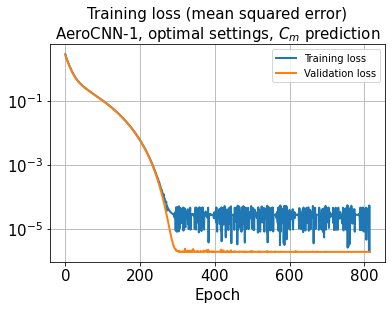

In [31]:
hist = history.history
plt.plot(hist['loss'], lw=2, label='Training loss')
plt.plot(hist['val_loss'], lw=2, label='Validation loss')
plt.title('Training loss (mean squared error)\nAeroCNN-1, optimal settings, $C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
#plt.ylim([5e-5, 1e-1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "TrainingLoss_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

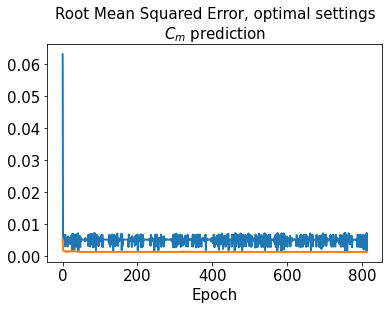

In [32]:
plt.plot(hist['rmse'], lw=2)
plt.plot(hist['val_rmse'], lw=2)
plt.title('Root Mean Squared Error, optimal settings\n$C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

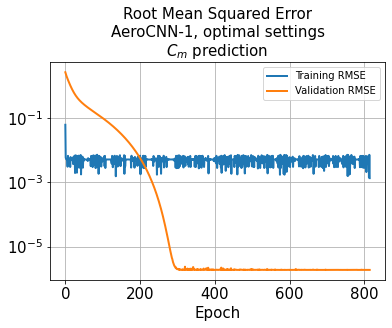

In [33]:
plt.plot(hist['rmse'], lw=2, label='Training RMSE')
plt.plot(hist['val_loss'], lw=2, label='Validation RMSE')
plt.title('Root Mean Squared Error\nAeroCNN-1, optimal settings\n$C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "RMSE_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [34]:
train_results = model.evaluate([x_train, x_para_train], y_train)

1750/1750 [==============================] - 5s 3ms/step - loss: 2.6780e-05 - rmse: 0.0052


In [35]:
val_results = model.evaluate([x_val, x_para_val], y_val)

501/501 [==============================] - 2s 4ms/step - loss: 1.8596e-06 - rmse: 0.0014


In [36]:
test_results = model.evaluate([x_test, x_para_test], y_test)

250/250 [==============================] - 1s 4ms/step - loss: 7.0151e-07 - rmse: 8.3718e-04


In [37]:
decoded_train_ = model.predict([x_train, x_para_train])
decoded_val_ = model.predict([x_val, x_para_val])
decoded_test_ = model.predict([x_test, x_para_test])

250/250 [==============================] - 1s 2ms/step


In [38]:
def define_index(cm, y):
    return np.unique(np.where(np.isin(cm, y)))

In [39]:
def error_absolute(y_pred, y_true):
    return np.abs(y_pred - y_true)

In [40]:
# Denormalize 
def denormalize(y):
    return y*(np.max(cm)-np.min(cm))+np.min(cm)

In [41]:
index_train = define_index(y, y_train)
index_val = define_index(y, y_val)
index_test = define_index(y, y_test)

In [42]:
y_train_denorm = denormalize(y_train)
y_val_denorm = denormalize(y_val)
y_test_denorm = denormalize(y_test)

In [43]:
y_train_denorm

array([[ 0.00052779],
       [ 0.011977  ],
       [ 0.043392  ],
       ...,
       [ 0.16452   ],
       [ 0.0357641 ],
       [-0.025307  ]])

In [44]:
y_val_denorm

array([[ 0.0350805 ],
       [ 0.04206   ],
       [ 0.019488  ],
       ...,
       [-0.02417852],
       [ 0.17659   ],
       [ 0.11899   ]])

In [45]:
y_test_denorm

array([[ 0.029475  ],
       [ 0.024164  ],
       [ 0.026589  ],
       ...,
       [ 0.17495   ],
       [ 0.03508253],
       [-0.0329    ]])

In [46]:
y_train = denormalize(y_train)
y_val = denormalize(y_val)
y_test = denormalize(y_test)

In [83]:
index_val

array([    0,     4,     6, ..., 79980, 79981, 79997], dtype=int64)

In [47]:
decoded_train = denormalize(decoded_train_)
decoded_val = denormalize(decoded_val_)
decoded_test = denormalize(decoded_test_)

In [48]:
model_directory = "D:\\TrainedModels\\20221218"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
os.chdir(model_directory)
model_name = "20221218unsteadyValidation_AeroCNN1_val_"+str(val_rate)+"_test"+str(test_rate)+ "_" + str(n_layers) +"layers_"+str(n_units)+"unitsCmPrediction.h5"
model.save(model_name, overwrite=True, include_optimizer=True, save_format='h5')

In [49]:
error_train_abs = error_absolute(decoded_train, y_train)
error_val_abs = error_absolute(decoded_val, y_val)
error_test_abs = error_absolute(decoded_test, y_test)

In [50]:
os.chdir(storage_dir)

In [51]:
def l2_error(y_pred, y_real):
    return np.sqrt(np.sum((y_pred - y_real)**2) / np.sum(y_real**2))

def mape(y_pred, y_real):
    return 100/len(y_real)*np.sum(np.abs((y_real-y_pred)/y_real))

def smape(y_pred, y_real):
    return 100*np.sum(np.abs(y_pred-y_real))/np.sum(y_real+y_pred)

In [52]:
l2_error_train = l2_error(decoded_train, y_train)
mape_train = mape(decoded_train, y_train)
print(l2_error_train)
print(mape_train)

0.9897896852640387
716.411670069915


In [53]:
l2_error_val = l2_error(decoded_val, y_val)
mape_val= mape(decoded_val, y_val)
print(l2_error_val)
print(mape_val)

0.8854323330122715
491.60756734466923


In [54]:
l2_error_test = l2_error(decoded_test, y_test)
mape_test= mape(decoded_test, y_test)
print(l2_error_test)
print(mape_test)

0.7680019546893275
580.471334369528


In [55]:
l2_error_train_list = []
for i in range(0, len(x_train)):
    l2_error_train_data = l2_error(decoded_train[i], y_train[i])
    l2_error_train_list.append(l2_error_train_data)

In [56]:
l2_error_val_list = []
for i in range(0, len(x_val)):
    l2_error_val_data = l2_error(decoded_val[i], y_val[i])
    l2_error_val_list.append(l2_error_val_data)

In [57]:
l2_error_test_list = []
for i in range(0, len(x_test)):
    l2_error_test_data = l2_error(decoded_test[i], y_test[i])
    l2_error_test_list.append(l2_error_test_data)

In [58]:
mape_train_list = []
for i in range(0, len(x_train)):
    mape_train_data = mape(decoded_train[i], y_train[i])
    mape_train_list.append(mape_train_data)

In [59]:
mape_val_list = []
for i in range(0, len(x_val)):
    mape_val_data = mape(decoded_val[i], y_val[i])
    mape_val_list.append(mape_val_data)

In [60]:
mape_test_list = []
for i in range(0, len(x_test)):
    mape_test_data = mape(decoded_test[i], y_test[i])
    mape_test_list.append(mape_test_data)

In [84]:
def distribution_plot(y_pred, y_real, dataset="train"):
    dictionary_name = {"train":"training", "val":"validation", "test":"test"}
    dictionary_data = {"train":l2_error_train_list, "val":l2_error_val_list, "test":l2_error_test_list}
    dictionary_average = {"train":l2_error_train, "val":l2_error_val, "test":l2_error_test}
    plot_title = '$L_2$ error norm distribution - AeroCNN-1, unsteady, '+ dictionary_name.get(dataset) +'.\nValidation rate {0}, test rate {1}, {2} layers, {3} units ($C_m$)'.format(
        val_rate, test_rate, n_layers, n_units)
    plt.plot(np.linspace(1,y_real.shape[0],y_real.shape[0]), dictionary_average.get(dataset)*np.ones(y_real.shape[0],), 'k', lw=2.5)
    plt.scatter(np.linspace(1, y_real.shape[0], y_real.shape[0]), dictionary_data.get(dataset), c='b')
    plt.xlabel('Index', fontsize=15)
    plt.ylabel('$L_2$ error norm', fontsize=15)
    plt.yscale('log')
    plt.title(plot_title, fontsize=15)
    plt.grid()

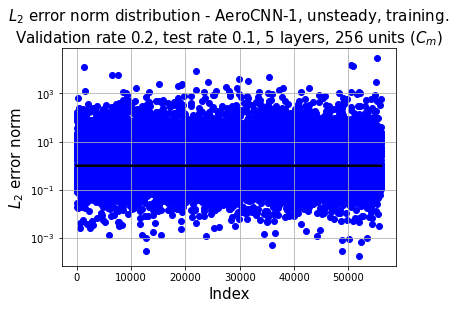

In [85]:
distribution_plot(decoded_train, y_train, dataset="train")
saveName = "trainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

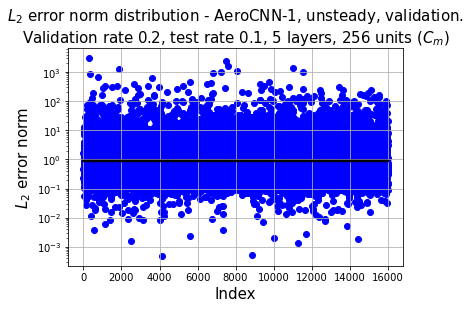

In [86]:
distribution_plot(decoded_val, y_val, dataset="val")
saveName = "validationErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

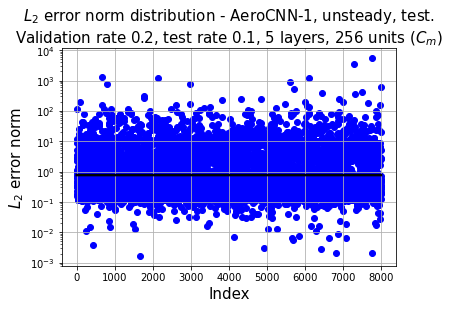

In [87]:
distribution_plot(decoded_test, y_test, dataset="test")
saveName = "testErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [65]:
predicted = model.predict([x, x_para])

2500/2500 [==============================] - 5s 2ms/step


In [77]:
x[0]

array([[[ 0.02689964],
        [ 0.04143287],
        [ 0.05175948],
        [ 0.05970001],
        [ 0.06610518],
        [ 0.07134219],
        [ 0.07565321],
        [ 0.07919204],
        [ 0.0820983 ],
        [ 0.084467  ],
        [ 0.08633761],
        [ 0.08777314],
        [ 0.08883208],
        [ 0.08952548],
        [ 0.08990554],
        [ 0.089997  ],
        [ 0.08980556],
        [ 0.08938369],
        [ 0.08872199],
        [ 0.08784509],
        [ 0.08678237],
        [ 0.08553293],
        [ 0.08410421],
        [ 0.08252498],
        [ 0.08080335],
        [ 0.07892746],
        [ 0.07692563],
        [ 0.07480527],
        [ 0.07256919],
        [ 0.07021322],
        [ 0.06775739],
        [ 0.06520957],
        [ 0.06255477],
        [ 0.05981111],
        [ 0.05698391],
        [ 0.0540609 ],
        [ 0.05105962],
        [ 0.04797466],
        [ 0.04480337],
        [ 0.04155417],
        [ 0.03821789],
        [ 0.0348029 ],
        [ 0.03130481],
        [ 0

In [66]:
np.max(x)

0.0899969955485105

In [67]:
t_train = t[index_train]
t_val = t[index_val]
t_test = t[index_test]

In [68]:
iTrain=[]
iVal=[]
iTest=[]
for i, index in enumerate(index_train):
    iTrain.append(y[index])
for k , index in enumerate(index_val):
    iVal.append(y[index])
for j, index in enumerate(index_test):
    iTest.append(y[index])

In [69]:
iTrain = np.array(iTrain)
iVal = np.array(iVal)
iTest = np.array(iTest)

In [74]:
predicted

array([[0.00158835],
       [0.00158835],
       [0.00158835],
       ...,
       [0.00158835],
       [0.00158835],
       [0.00158835]], dtype=float32)

In [70]:
def Cm_trainTestSplit_Plot(i, Cm_true, cm_pred, tTrain, tTest, iTrain, iTest):
    
    title_0_Cm = 'Gurney flap not attached (NACA0018)\n$C_m$ prediction, $L_2$ error=%.4f' % l2_error_Cm    
    title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, $L_2$ error=%.4f'%(l2_error_Cm)
    
    if i==0:
        title_Cm = title_0_Cm
        savename1 = "CmComparison_NACA0018.jpg"
    else:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    
    # CD graph plot
    plt.plot(t[:5000], Cm_true, 'k-', label='Ground truth')
    plt.plot(t[:5000], cm_pred, 'k--', label='Predicted value')
    plt.scatter(tTrain, iTrain, color='b', label='Training set')
    plt.scatter(tVal, iVal, color='g', label='Validation set')
    plt.scatter(tTest, iTest, color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper left')
#     plt.ylim([0, 0.12])
    plt.grid()
    plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

NACA0018 airfoil without Gurney flap
L2 error of Cm: 0.4438


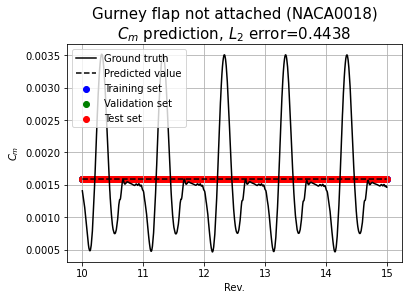

L2 error of Cm: 0.4885


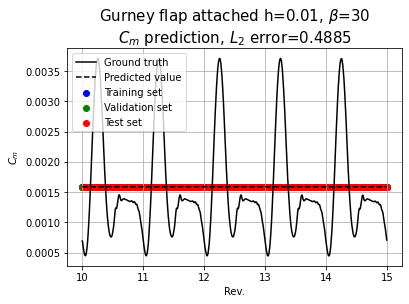

L2 error of Cm: 0.4827


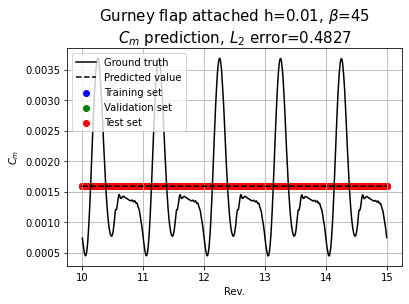

L2 error of Cm: 0.4690


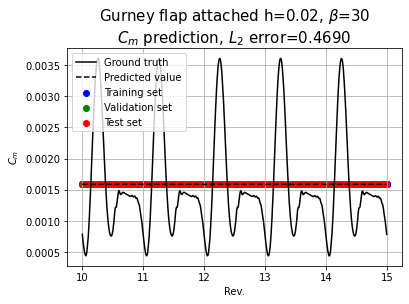

L2 error of Cm: 0.4644


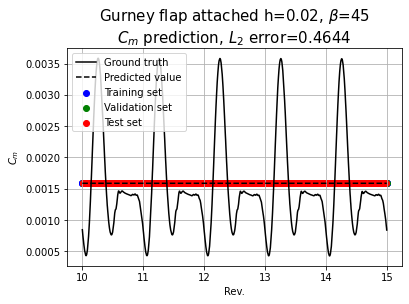

L2 error of Cm: 0.4468


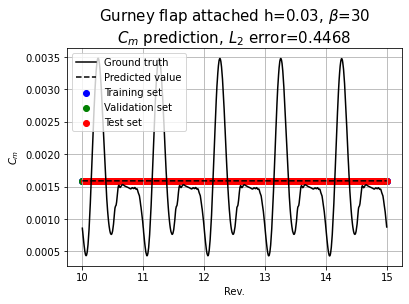

L2 error of Cm: 0.4502


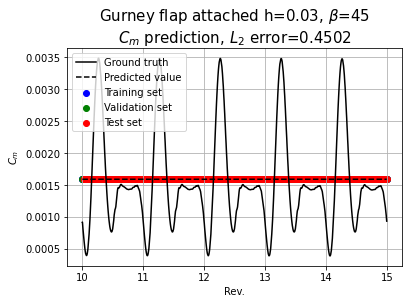

L2 error of Cm: 0.9931


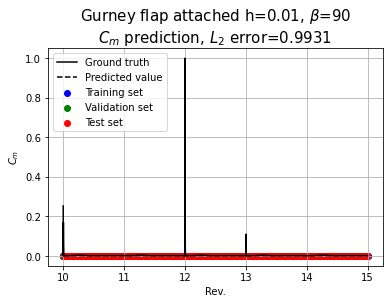

L2 error of Cm: 0.4656


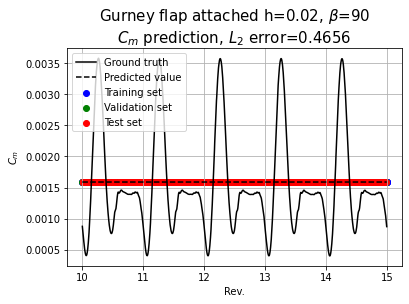

L2 error of Cm: 0.4543


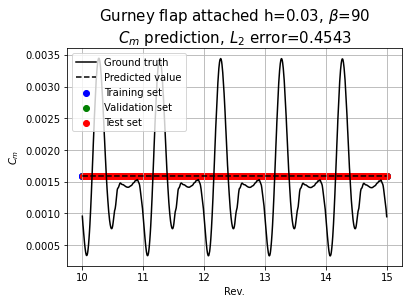

L2 error of Cm: 0.4831


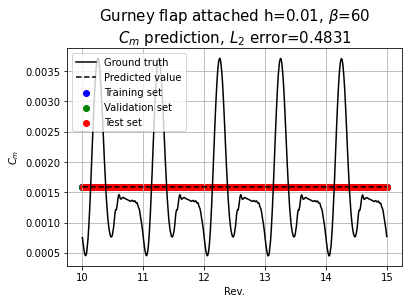

L2 error of Cm: 0.4612


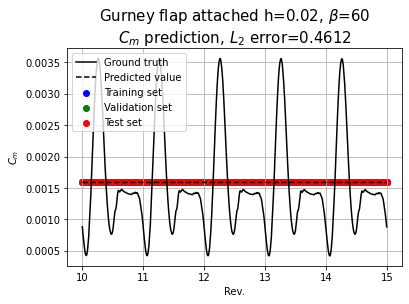

L2 error of Cm: 0.4479


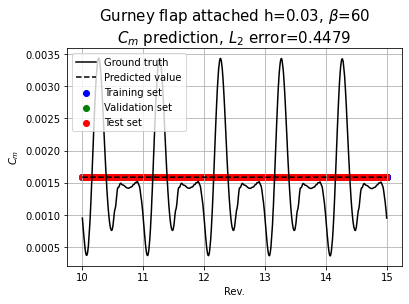

L2 error of Cm: 0.4814


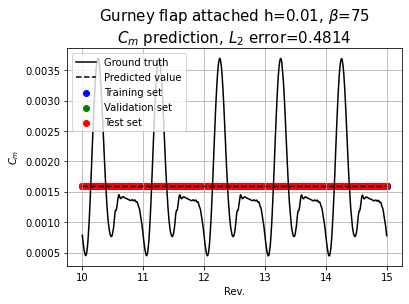

L2 error of Cm: 0.4602


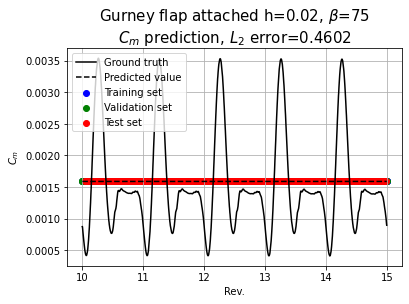

L2 error of Cm: 0.4502


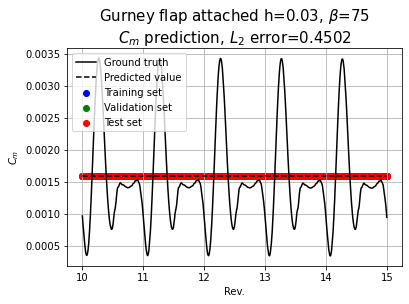

In [71]:
h = [0, 0.01, 0.01, 0.02, 0.02, 0.03, 0.03, 0.01, 0.02, 0.03, 0.01, 0.02, 0.03, 0.01, 0.02, 0.03]
beta = [0, 30, 45, 30, 45, 30, 45, 90, 90, 90, 60, 60, 60, 75, 75, 75]
for i in range(0, 16):
    # Index from each dataset
    iTrain = []
    iVal = []
    iTest = []
    
    # Index from input data (alpha, in this case)
    t_train = []
    t_val = []
    t_test = []
    
    predictedValue = predicted[t_len*i:t_len*(i+1),:]
    y_corres = y[t_len*i:t_len*(i+1),:]
    
    l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    if i==0:
        print('NACA0018 airfoil without Gurney flap\nL2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    else:
        print('L2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    
    cm_pred = predictedValue#denormalize(predictedValue)
    Cm_true = y_corres#denormalize(y_corres)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        iTrain.append(predicted[index])
    for jj, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        iVal.append(predicted[index])    
    for kk, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & (index_test>=i*t_len))]):
        iTest.append(predicted[index])
        
#     iTrain = denormalize(np.array(iTrain))
#     iTest = denormalize(np.array(iTest))
#     iVal = denormalize(np.array(iVal))
    iTrain = np.array(iTrain)
    iVal = np.array(iVal)
    iTest = np.array(iTest)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        t_train.append(t[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        t_val.append(t[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & ((index_test>=i*t_len)))]):
        t_test.append(t[index])
        
    tTrain = np.array(t_train)
    tVal = np.array(t_val)
    tTest = np.array(t_test)
    
    Cm_trainTestSplit_Plot(i, Cm_true, cm_pred, tTrain, tTest, iTrain, iTest)